In [1]:
%cd "baselines/Copolymer"

/home/zmao_umass_edu/baselines/Copolymer


In [2]:
import pandas as pd
import numpy as np
import pickle

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Dense, Flatten, Activation, ZeroPadding2D
from tensorflow.keras.layers import LSTM, Embedding, Bidirectional, TimeDistributed, Reshape, Dropout
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import time
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import random
from numpy.random import seed
import tensorflow
from keras.layers import Input
from keras.models import Model
from keras.layers import Concatenate
import argparse
import os


2023-03-05 00:59:37.090755: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /modules/apps/julia/1.7.2/lib
2023-03-05 00:59:37.090854: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Using TensorFlow backend.


In [3]:
#read in the reference data
DF = pd.read_csv('datasets/Dataset 1.csv') #to be comparable with the size of other datasets, select ~5000 data points from the reference
DF['TRIMER_mol'] = DF['TRIMER'].apply(Chem.MolFromSmiles)
DF = DF.dropna()
DF = DF.head(1000)

In [5]:
DF

,TRIMER,Excitation Energy (eV),IP (eV),EA (eV),Calib. IP (eV),Calib. EA (eV),Calib. Excitation Energy (eV),TRIMER_mol
0,[H]C1=C([H])C(C2C([H])=C(F)C(=C([H])C=2Cl)C2=C...,3.40548,6.352397,1.481368,6.330281,0.668059,3.371348,<rdkit.Chem.rdchem.Mol object at 0x7f4a2bea1520>
1,[H]C1=C([H])C(C2=C([H])C(Cl)=C(C([H])=C2F)C2=C...,3.36813,6.319819,1.484588,6.300635,0.671021,3.340348,<rdkit.Chem.rdchem.Mol object at 0x7f4a2bea1640>
2,[H]C1=NC(C#N)=C(C2C([H])=C3C(=O)C(=O)N([H])C3=...,1.88575,6.585175,3.063124,6.542109,2.123274,2.109973,<rdkit.Chem.rdchem.Mol object at 0x7f4a2bea1820>
3,[H]C1=NC(C#N)=C(C2C([H])=C(C3=NC(C#N)=C([H])N3...,1.86334,6.608289,3.064964,6.563143,2.124967,2.091372,<rdkit.Chem.rdchem.Mol object at 0x7f4a2bea15e0>
4,[H]C(=O)C1=C([H])C(C2N=C([H])C3=C([H])C([H])=C...,2.84523,6.694830,2.420412,6.641895,1.531979,2.906341,<rdkit.Chem.rdchem.Mol object at 0x7f4a2bea1700>
...,...,...,...,...,...,...,...,...
995,[H]C1=C([H])C(C2N=C(C([H])=C(C=2[N+](=O)[O-])N...,2.52153,6.653971,2.612692,6.604714,1.708877,2.637670,<rdkit.Chem.rdchem.Mol object at 0x7f4a2d229400>
996,[H]C1=NC(=C([H])C2=C([H])C([H])=C([H])C([H])=C...,2.85851,5.949540,1.779540,5.963681,0.942377,2.917363,<rdkit.Chem.rdchem.Mol object at 0x7f4a2d229460>
997,[H]C1=NC(=C([H])C2=C([H])C([H])=C([H])C([H])=C...,2.94566,5.930066,1.716796,5.945960,0.884652,2.989698,<rdkit.Chem.rdchem.Mol object at 0x7f4a2d2294c0>
998,[H]C1N=C(N=C(C=1C1C(=C([H])C([H])=C(C=1C([H])(...,2.95064,5.897488,1.490384,5.916314,0.676353,2.993831,<rdkit.Chem.rdchem.Mol object at 0x7f4a2d229520>


In [6]:
mol1 = DF.loc[0]["TRIMER_mol"]
mol1.GetNumAtoms()

28

In [7]:
mol1.GetNumBonds()

32

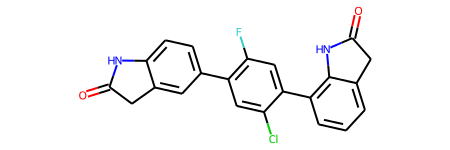

In [8]:
mol1

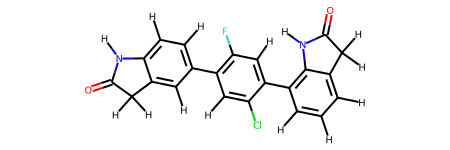

In [9]:
Chem.AddHs(mol1)

In [10]:
from rdkit.Chem import PandasTools
DF_small = DF.head().copy()
PandasTools.AddMoleculeColumnToFrame(DF_small, smilesCol = 'TRIMER', molCol = 'TRIMER_mol')

,TRIMER,Excitation Energy (eV),IP (eV),EA (eV),Calib. IP (eV),Calib. EA (eV),Calib. Excitation Energy (eV),TRIMER_mol
0,[H]C1=C([H])C(C2C([H])=C(F)C(=C([H])C=2Cl)C2=C...,3.40548,6.352397,1.481368,6.330281,0.668059,3.371348,
1,[H]C1=C([H])C(C2=C([H])C(Cl)=C(C([H])=C2F)C2=C...,3.36813,6.319819,1.484588,6.300635,0.671021,3.340348,
2,[H]C1=NC(C#N)=C(C2C([H])=C3C(=O)C(=O)N([H])C3=...,1.88575,6.585175,3.063124,6.542109,2.123274,2.109973,
3,[H]C1=NC(C#N)=C(C2C([H])=C(C3=NC(C#N)=C([H])N3...,1.86334,6.608289,3.064964,6.563143,2.124967,2.091372,
4,[H]C(=O)C1=C([H])C(C2N=C([H])C3=C([H])C([H])=C...,2.84523,6.694830,2.420412,6.641895,1.531979,2.906341,

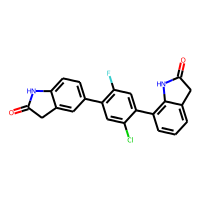
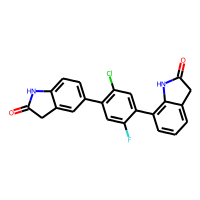
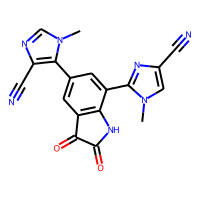
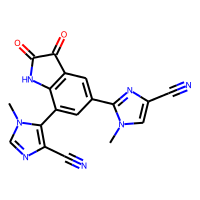
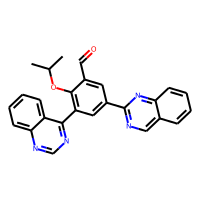

In [11]:
DF_small.head()

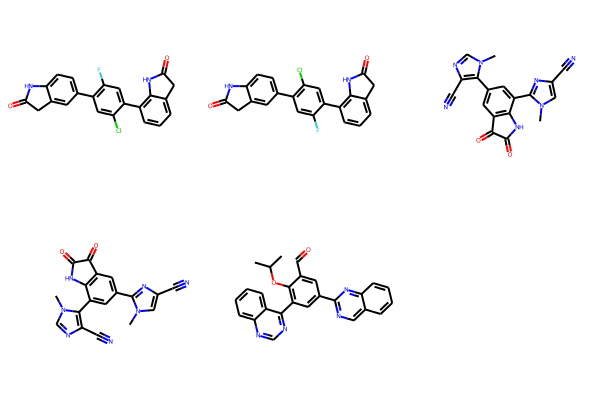

In [12]:
Chem.Draw.MolsToGridImage(list(DF_small.TRIMER_mol))

In [ ]:
DF['TRIMER_mol']

0        <rdkit.Chem.rdchem.Mol object at 0x7fa86d4e8280>
1        <rdkit.Chem.rdchem.Mol object at 0x7fa86d4e83a0>
2        <rdkit.Chem.rdchem.Mol object at 0x7fa86d4e8580>
3        <rdkit.Chem.rdchem.Mol object at 0x7fa86d4e8340>
4        <rdkit.Chem.rdchem.Mol object at 0x7fa86d4e8460>
                               ...                       
47983    <rdkit.Chem.rdchem.Mol object at 0x7fa86e48aac0>
47984    <rdkit.Chem.rdchem.Mol object at 0x7fa86e48ab20>
47985    <rdkit.Chem.rdchem.Mol object at 0x7fa86e48ab80>
47986    <rdkit.Chem.rdchem.Mol object at 0x7fa86e48abe0>
47987    <rdkit.Chem.rdchem.Mol object at 0x7fa86e48ac40>
Name: TRIMER_mol, Length: 47988, dtype: object

# Morgan Fingerprints 

1. Choose a radius: The first step in generating a Morgan fingerprint is to choose a radius value. The radius value determines how many atoms away from the central atom should be considered when generating the fingerprint. A typical radius value is 2, which means that the atoms up to 2 bonds away from the central atom will be considered.

2. Generate atom-centered environments: Once the radius is chosen, the next step is to generate atom-centered environments. For each atom in the molecule, a circular environment is generated that includes all atoms within the chosen radius. The circular environment is centered on the current atom and includes all the bonds and atoms up to the chosen radius away from it.

3. Generate substructures for each environment: Once the environments are generated, substructures are generated for each environment. The substructures represent the features of the environment that are important for fingerprinting. The substructures are generated by hashing the paths in the circular environment and creating a unique identifier for each path.

4. Hash substructures to generate fingerprint: Finally, the substructures are hashed to generate the Morgan fingerprint. The hashing is done using a hash function that takes the substructure identifiers as input and generates a unique bit vector for each substructure. The bit vector is the fingerprint for that substructure and represents the presence or absence of that substructure in the molecule.

5. Combine all substructure fingerprints: The Morgan fingerprint is generated by combining all of the substructure fingerprints generated in step 4. The resulting fingerprint is a binary bit vector where each bit represents the presence or absence of a particular substructure in the molecule.

In [4]:
fp = DF['TRIMER_mol'].apply(lambda m: AllChem.GetMorganFingerprint(m, radius=3))
fp_n = fp.apply(lambda m: m.GetNonzeroElements()) #dict, each key represent a substructure in bit digits

In [14]:
fp[0]

In [5]:
fp[0].GetNonzeroElements()

{10565946: 2,
 98513984: 1,
 179432116: 1,
 278534794: 1,
 467123520: 1,
 587511141: 1,
 661888323: 1,
 789496286: 1,
 845999250: 1,
 864942730: 2,
 882399112: 1,
 925707654: 1,
 951226070: 4,
 994485099: 3,
 997801163: 1,
 1016841875: 1,
 1172939177: 1,
 1323467736: 1,
 1427929407: 1,
 1455745809: 1,
 1500223086: 1,
 1616159509: 1,
 1836363923: 1,
 1842898132: 2,
 1857396528: 1,
 1866149706: 1,
 1866436192: 1,
 2051343976: 1,
 2132511834: 2,
 2144040306: 1,
 2161076531: 1,
 2286444213: 1,
 2296493092: 2,
 2302929571: 1,
 2349689990: 1,
 2353112200: 1,
 2424973678: 1,
 2602464909: 2,
 2646407751: 1,
 2739494946: 1,
 2753990149: 1,
 2806469715: 1,
 2844346206: 1,
 2850656190: 1,
 2851977513: 1,
 2968968094: 2,
 2969923882: 1,
 2985257562: 1,
 3157391782: 1,
 3217380708: 12,
 3218693969: 8,
 3234104871: 2,
 3337745083: 1,
 3376178981: 1,
 3452535345: 1,
 3462479532: 1,
 3647526986: 1,
 3658364521: 1,
 3692055567: 1,
 3745256908: 1,
 3777038188: 1,
 3863608508: 1,
 3866353766: 1,
 3941569

In [ ]:
print(dir(fp[0]))


['GetLength', 'GetNonzeroElements', 'GetTotalVal', 'ToBinary', 'UpdateFromSequence', '__add__', '__and__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getinitargs__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__idiv__', '__imul__', '__init__', '__init_subclass__', '__instance_size__', '__isub__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__or__', '__reduce__', '__reduce_ex__', '__repr__', '__safe_for_unpickling__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__weakref__']


In [ ]:
#Compare similarity between two fingerprints

fp1 = fp[0]
fp2 = fp[1]

rdkit.DataStructs.DiceSimilarity(fp1,fp2)

0.9038461538461539

In [ ]:
rdkit.DataStructs.DiceSimilarity(fp1,fp1)

1.0

In [ ]:
fp1

In [ ]:
type(fp_n[0])

dict

In [6]:
#collect unique substructures in a list
HashCode = []
for i in fp_n:
    for j in i.keys():
        HashCode.append(j)
unique_set = set(HashCode)
unique_list = list(unique_set)  #list of unique substructures 
Corr_df = pd.DataFrame(unique_list).reset_index()

In [ ]:
Corr_df.head()

,index,0
0,0,2584477697
1,1,2023489538
2,2,24641539
3,3,1011613704
4,4,2694578185


In [16]:
len(unique_list)

12511

In [ ]:
len(fp_n)

47988

In [7]:
#calculate the appearance of each substructure in the whole dataset. 130451 x 47988 size in total
MY_finger = []
for polymer in fp_n:
    my_finger = [0] * len(unique_list)
    for key in polymer.keys():
        index = Corr_df[Corr_df[0] == key]['index'].values[0]
        my_finger[index] = polymer[key]
    MY_finger.append(my_finger)
MY_finger_dataset_1000 = pd.DataFrame(MY_finger)
MY_finger_dataset_1000.to_csv('MY_finger_dataset_1000.csv', index=False)

In [8]:
#MY_finger_dataset=pd.read_csv('MY_finger_dataset.csv').reset_index()
MY_finger_dataset = MY_finger_dataset_1000

In [9]:
Zero_Sum = (MY_finger_dataset == 0).astype(int).sum()
NumberOfZero = 4670 # a optimized parameter for feature filter: if more than 4670 of the 5000 samples do not pocess one substrcture, then remove this substructure from the feature matrix
X = MY_finger_dataset[Zero_Sum[Zero_Sum < NumberOfZero].index]

In [29]:
X.shape

(1000, 12511)

In [10]:
# input for RNN
Mix_X_100Block = []
for i in range(len(DF)):
    Sequency_X = [0 for a in range(100)]
    for j in range(100):
            if j%2 == 0:
                Sequency_X[j] = list(X.iloc[i].values)
            else:
                Sequency_X[j] = list(X.iloc[i].values)
    Mix_X_100Block.append(Sequency_X)   
Mix_X_100Block = np.array(Mix_X_100Block)

In [15]:
Mix_X_100Block.shape

(1000, 100, 12511)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(Mix_X_100Block, DF['IP (eV)'], test_size=0.2, random_state=11)

In [21]:
# model setup using the optimized architecture for IP
LSTMunits = 20 # hyperprameter for LSTM
RNNmodel = Sequential()
RNNmodel.add(Bidirectional(LSTM(LSTMunits, return_sequences=True), input_shape=(100,12511)))
RNNmodel.add(Bidirectional(LSTM(LSTMunits, return_sequences=True)))
RNNmodel.add(TimeDistributed(tensorflow.keras.layers.Dense(int(LSTMunits/2), activation="relu")))
RNNmodel.add(Reshape((int(LSTMunits/2*100),)))
RNNmodel.add(Dense(1))

In [22]:
RNNmodel.compile(loss='mse', optimizer='adam')
RNNmodel.fit(X_train, y_train, validation_split=0.2, epochs=120, batch_size=64)

Epoch 1/120
10/10 [==============================] - 10s 981ms/step - loss: 16.4998 - val_loss: 1.2958
Epoch 2/120
10/10 [==============================] - 8s 802ms/step - loss: 1.9288 - val_loss: 0.4124
Epoch 3/120
10/10 [==============================] - 8s 844ms/step - loss: 0.6624 - val_loss: 0.1510
Epoch 4/120
10/10 [==============================] - 8s 806ms/step - loss: 0.2730 - val_loss: 0.1345
Epoch 5/120
10/10 [==============================] - 8s 821ms/step - loss: 0.1444 - val_loss: 0.1270
Epoch 6/120
10/10 [==============================] - 8s 799ms/step - loss: 0.0921 - val_loss: 0.0934
Epoch 7/120
10/10 [==============================] - 7s 747ms/step - loss: 0.0580 - val_loss: 0.0791
Epoch 8/120
10/10 [==============================] - 8s 752ms/step - loss: 0.0358 - val_loss: 0.0642
Epoch 9/120
10/10 [==============================] - 8s 786ms/step - loss: 0.0230 - val_loss: 0.0559
Epoch 10/120
10/10 [==============================] - 8s 793ms/step - loss: 0.0156 - val_

In [24]:
filepath = 'Binary_IP_RNN_1000.model'
save_model(RNNmodel, filepath, save_format='h5')

In [25]:
# model evaluation
print("model performance (IP)")
y_pred_train = RNNmodel.predict((X_train))
print("Train set R^2: %.2f" % r2_score(y_train, y_pred_train))
print("Train MAE score: %.2f" % mean_absolute_error(y_train, y_pred_train))
print("Train RMSE score: %.2f" % np.sqrt(mean_squared_error(y_train, y_pred_train)))
y_pred_test = RNNmodel.predict((X_test))
print("Test set R^2: %.2f" % r2_score(y_test, y_pred_test))
print("Test MAE score: %.2f" % mean_absolute_error(y_test, y_pred_test))
print("Test RMSE score: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred_test)))


model performance (IP)
Train set R^2: 0.96
Train MAE score: 0.03
Train RMSE score: 0.09
Test set R^2: 0.79
Test MAE score: 0.16
Test RMSE score: 0.22


In [26]:
X_train, X_test, y_train, y_test = train_test_split(Mix_X_100Block, DF['EA (eV)'], test_size=0.2, random_state=11)

In [27]:
# model setup using the optimized architecture for EA
LSTMunits = 20 # hyperprameter for LSTM
RNNmodel = Sequential()
RNNmodel.add(Bidirectional(LSTM(LSTMunits, return_sequences=True), input_shape=(100,12511)))
RNNmodel.add(Bidirectional(LSTM(LSTMunits, return_sequences=True)))
RNNmodel.add(TimeDistributed(Dense(int(LSTMunits/2), activation="relu")))
RNNmodel.add(Reshape((int(LSTMunits/2*100),)))
RNNmodel.add(Dense(1))

In [ ]:
RNNmodel.compile(loss='mse', optimizer='adam')
RNNmodel.fit(X_train, y_train, validation_split=0.2, epochs=120, batch_size=64)
